In [7]:
from qiskit import *
from qiskit.circuit.library import iSwapGate
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('physchem.mplstyle')

from pyscf import gto, scf
from functools import reduce

import scipy.linalg

SILENT_MODE = 0

In [2]:
def givens_(qc,x,pos):
    sqrt_iSWAP = iSwapGate().power(1/2)
    qc.append(sqrt_iSWAP, pos)
    qc.rz(x,pos[0])
    qc.rz(-x-np.pi,pos[1])
    qc.append(sqrt_iSWAP, pos)
    qc.rz(np.pi,pos[1])
    
    return qc

def givens_mat(n,p,q,theta):
    mat = np.zeros((n,n))
    
    for i in range(n):
        mat[i,i] += int((i!=p) or (i!=q))
        
    mat[p,p] = np.cos(theta)
    mat[p,q] = -np.sin(theta)
    mat[q,p] = np.sin(theta)
    mat[q,q] = np.cos(theta)
    
    return mat


def lowdin(s):
    ''' new basis is |mu> c^{lowdin}_{mu i} '''
    e, v = scipy.linalg.eigh(s)
    idx = e > 1e-15
    return np.dot(v[:,idx]/np.sqrt(e[idx]), v[:,idx].conj().T)

def caolo(s):
    return lowdin(s)

def cloao(s):
    return lowdin(s) @ s 


def get_thetas(mo_coeff):
    # mo_coeff is of shape (n,occ)
    
    ceff = mo_coeff[:]
    n = ceff.shape[0]
    occ = 3
    
    for i in range(occ-1):
        for j in range(occ-1-i):
            ceff = ceff @ givens_mat(n,j,j+1,np.arctan(-ceff[n-1-i,j]/ceff[n-1-i,j+1]))

    thetas = []
    
    pairs = ([2,3,0],[1,2,0],[3,4,1],[0,1,0],[2,3,1],[4,5,2],[1,2,1],[3,4,2],[2,3,2])
    
    for i in range(len(pairs)):
        theta = np.arctan(-ceff[pairs[i][1],pairs[i][2]]/ceff[pairs[i][0],pairs[i][2]])
        thetas.append(theta)
        ceff = givens_mat(n,pairs[i][0],pairs[i][1],theta) @ ceff
        
    for i in range(occ-1):
        for j in range(occ,2*occ-1-i):
            ceff = ceff @ givens_mat(n,j,j+1,np.arctan(-ceff[n-1-i,j]/ceff[n-1-i,j+1]))
        
    return thetas[::-1], ceff

def get_z(counts):
    m = np.zeros(6)
    for item in counts:
        for i in range(6):
            if int(item[0][i]):
                m[i] -= item[1]
            else:
                m[i] += item[1]
    return m

In [3]:
def get_mol_H6(bl):
    mol = gto.M(atom='''
            H 0. 0. %.8f
            H 0. 0. %.8f
            H 0. 0. %.8f
            H 0. 0. %.8f
            H 0. 0. %.8f
            H 0. 0. %.8f
        '''%tuple([bl * i for i in range(6)]),
        basis='sto-3g', symmetry=0 ,spin = 0,charge = 0,verbose= 0)
    
    return mol

lengths = np.linspace(0.5,2.5,6)
cur_length = 1

# classical HF
mol = get_mol_H6(lengths[cur_length])
mf = scf.HF(mol)
mf.kernel(verbose=0)

# orthogonalization
mo_coeff = cloao(mf.get_ovlp()) @ mf.mo_coeff

# Givens reduction for VQE initial guess
thetas, ceff = get_thetas(mo_coeff)

# Simulation Shots
shots = 1024

In [18]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)
    
if not SILENT_MODE:
    fig = circuit.draw('mpl')
    fig.savefig('1.png')

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ii = (1-m_i)/2

print(d_ii)

[0.50976562 0.49609375 0.47265625 0.50683594 0.49609375 0.51855469]


In [5]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    circuit.draw('mpl')   

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij1o = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(0,5,2)])

print(d_ij1o)

[0.45263672 0.40820312 0.43896484]


In [6]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(1,5,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    circuit.draw('mpl')   

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij1e = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(1,4,2)])

print(d_ij1e)

[0.21142578 0.22021484]


In [7]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    circuit.draw('mpl')   

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij2o = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(0,5,2)])

print(d_ij2o)

[ 0.00488281  0.11230469 -0.00878906]


In [8]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
circuit.barrier(range(6))
    
for i in range(1,5,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    circuit.draw('mpl')   

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij2e = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(1,4,2)])

print(d_ij2e)

[-0.18847656 -0.18408203]


In [8]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    fig = circuit.draw('mpl')   
    fig.savefig('2.png')

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij3o = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(0,5,2)])

print(d_ij3o)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


[-0.015625   -0.04052734 -0.00830078]


In [19]:
circuit = QuantumCircuit(6)

for i in range(3):
    circuit.x(i)
    
pairs = ([2,3],[3,4],[1,2],[4,5],[2,3],[0,1],[3,4],[1,2],[2,3])

for i in range(9):
    givens_(circuit,-thetas[i],pairs[i])
    
circuit.barrier(range(6))
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(0,6,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
for i in range(1,5,2):
    circuit.swap(i,i+1)
    circuit.cp(np.pi,i+1,i)
    
circuit.barrier(range(6))
    
for i in range(1,5,2):
    circuit.rz(np.pi/4,i)
    circuit.rz(-np.pi/4,i+1)
    
    sqrt_iSWAP = iSwapGate().power(1/2)
    circuit.append(sqrt_iSWAP, (i,i+1))
    
meas = QuantumCircuit(6, 6)
meas.barrier(range(6))
meas.measure(range(6), range(6))
circuit.add_register(meas.cregs[0])
circuit = circuit.compose(meas)

if not SILENT_MODE:
    circuit.draw('mpl')   

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if not SILENT_MODE:
    from qiskit.visualization import plot_histogram
    plot_histogram(counts)
    
m_i = get_z(counts.items())/shots
d_ij3e = np.asarray([(m_i[i]-m_i[i+1])/4 for i in range(1,4,2)])

print(d_ij3e)

[-0.01220703 -0.00732422]


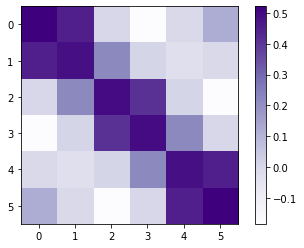

In [11]:
dm_cl = reduce(np.dot,(cloao(mf.get_ovlp()),mf.make_rdm1(),cloao(mf.get_ovlp()).conj().T))
plt.imshow(dm_cl/2,cmap='Purples')
plt.colorbar()

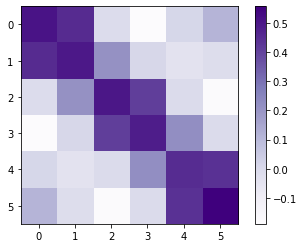

In [12]:
dm_qm = np.asarray([[d_ii[0],d_ij1o[0],d_ij3o[2],d_ij2e[0],d_ij3e[1],d_ij2o[1]],
                    [0      ,d_ii[1]  ,d_ij1e[0],d_ij2o[0],d_ij3o[1],d_ij3e[0]],
                    [0      ,0        ,d_ii[2]  ,d_ij1o[1],d_ij2o[2],d_ij2e[1]],
                    [0      ,0        ,0        ,d_ii[3]  ,d_ij1e[1],d_ij3o[0]],
                    [0      ,0        ,0        ,0        ,d_ii[4]  ,d_ij1o[2]],
                    [0      ,0        ,0        ,0        ,0        ,d_ii[5]  ]])

dm_qm = dm_qm+dm_qm.T-np.diag(d_ii)
plt.imshow(dm_qm,cmap='Purples')
plt.colorbar()

In [13]:
print('deriv from id',np.linalg.norm(dm_qm @ dm_qm - dm_qm))

deriv from id 0.052408701910871214


In [14]:
adm_cl = reduce(np.dot,(caolo(mf.get_ovlp()),dm_cl,caolo(mf.get_ovlp()).conj().T))
adm_qm = reduce(np.dot,(caolo(mf.get_ovlp()),dm_qm,caolo(mf.get_ovlp()).conj().T))*2

mf_qm = scf.HF(mol)
mf_qm.max_cycle = 0
mf_qm.kernel(adm_qm)


print('classical:',mf.energy_tot(dm=adm_cl))
print('quantum:',mf.energy_tot(dm=adm_qm))
print('pure quantum:',mf_qm.energy_tot())

classical: -3.160743363561985
quantum: -3.1551428370883636
pure quantum: -3.1606492359310954


In [15]:
'''
np.savetxt('H6_dm_cl-%.2f'%lengths[cur_length],dm_cl/2)
np.savetxt('H6_dm_qm-%.2f'%lengths[cur_length],dm_qm)

np.savetxt('H6_e-%.2f'%lengths[cur_length],(mf.energy_tot(dm=adm_cl),mf.energy_tot(dm=adm_qm),mf_qm.energy_tot()))
'''

"\nnp.savetxt('H6_dm_cl-%.2f'%lengths[cur_length],dm_cl/2)\nnp.savetxt('H6_dm_qm-%.2f'%lengths[cur_length],dm_qm)\n\nnp.savetxt('H6_e-%.2f'%lengths[cur_length],(mf.energy_tot(dm=adm_cl),mf.energy_tot(dm=adm_qm),mf_qm.energy_tot()))\n"